<a href="https://imla.hs-offenburg.de/"> 
![hs logo](../images/hs-logo.png)  
![IMLA Banner](../images/imla-banner.png)
</a>

# Magma Classification
In this domain objects on pictures of our soccer robot Sweaty shall be classified. From eight possible object classes the correct class should be recognized. The eight classes are:
  
 0 Ball  
 1 Goalpost  
 2 Obstacle  
 3 L-Line  
 4 X-Line  
 5 T-Line  
 6 Penalty Spot  
 7 Foot  

As at the beginning of every Python script, the Python modules to be used must be made known to the environment.

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam,Adagrad,Adamax,Adadelta,Nadam,RMSprop,SGD
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image as keras_image
from keras import backend as K
from keras.applications.vgg16 import VGG16 , preprocess_input,decode_predictions

from os.path import isfile

import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import cv2
import shutil
import random

Using TensorFlow backend.


In [2]:
from keras import backend as K
import tensorflow as tf
# For Jetson TX2!
# prevent Tensorflow to use all available memory 

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

## Constants

In [3]:
BATCH_SIZE = 256
EPOCH = 4
# Keras Optimizer: Adam, Adagrad, Adamax, Adadelta, Nadam, RMSprop, SGD
OPTIMIZER = Adam()

CNN_MODEL = 'MagmaCnnClassifier.hdf5'

DATA_SHAPE=(100, 100, 3)
TARGET_SHAPE = 8
TRAIN_DIR = "./data/training"
VAL_DIR = "./data/validation"
TEST_DIR = "./data/test"

LOGS_DIR = "./logs"

prediction_dir = "./data/prediction"

CATEGORIE_NAMES = ['BALL',]
CATEGORIES = ['0','1','2','3','4','5','6','7']
TESTING_SIZE = 20 #MAX = SIZE OF IMAGE

## Data Preparation & Augmentation


For the Mnist example, Keras provides functions to obtain the data set prepared in Training and Test as well as in X (independent variable (image)) and Y (dependent variable (class/number)) separately. This step must be performed manually for your own data records. However, Keras offers functions to read and prepare the data in this case, so-called generators. The [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) class exists for the image classification domain. When such an object is initialized, augmentation parameters (*rescale, rotation\_range,...*) can be defined that manipulate the images accordingly. The flow_from_directory method is used to define the directory and the target size for the images. 

Keras also determines the class labels from the folder structure of the training images. Images with lable *0* are stored in a folder _./data/train/0_ .
You can check this with a code cell  `!ls ./data/training` . 

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
# Do train/validation split with a single directory,
# depents on 'subset' param in flow_from...()
#    validation_split=0.9, 
)
val_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=DATA_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

val_generator = val_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=DATA_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=DATA_SHAPE[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 4914 images belonging to 8 classes.
Found 615 images belonging to 8 classes.
Found 618 images belonging to 8 classes.


## Model Definition

After the data set has been prepared for the training, the network structure is defined and the function for _loss_, _optimizer_ and _metrics_ is defined.

In [5]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=DATA_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(rate=0.5),
    Dense(units=512, activation='relu'),
    Dense(units=TARGET_SHAPE, activation='softmax'),
])

model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

## Keras Callbacks

By using the well-known TensorBoard Callback we get information about the training process again. In addition we use the ModelCheckpoint Callback for the persistent storage of the trained models.

In [6]:
sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())

tb_cb = TensorBoard(log_dir=LOGS_DIR+'/'+sub_dir,
                    write_graph=True,
                    write_images=True,
                    batch_size=BATCH_SIZE)

mc_cb = ModelCheckpoint(filepath=os.path.join(LOGS_DIR,sub_dir,CNN_MODEL),
                        verbose=1,
                        save_best_only=True)

callbacks = [tb_cb, mc_cb]

## Model Training

Since the training process in this scenario takes place with generators, the corresponding method must also be used ([fit_generator(..)](https://keras.io/models/sequential/#fit_generator)). The parameters to be defined include the generators (*train\_generator, val\_generator*) and the number of steps for training and validation (*steps\_per\_epoch, validation\_steps*) for each epoch.

In [7]:
history = model.fit_generator(generator=train_generator,
                              epochs=EPOCH,
                              validation_data=val_generator,
                              callbacks=callbacks,
                              steps_per_epoch=train_generator.n//BATCH_SIZE,
                              validation_steps=val_generator.n//BATCH_SIZE)

Epoch 1/4
19/19 [==============================] - 94s 5s/step - loss: 1.7065 - categorical_accuracy: 0.3812 - val_loss: 1.2355 - val_categorical_accuracy: 0.5918

Epoch 00001: val_loss improved from inf to 1.23549, saving model to ./logs\2020_01_21-13_04_05\MagmaCnnClassifier.hdf5
Epoch 2/4
19/19 [==============================] - 89s 5s/step - loss: 1.0414 - categorical_accuracy: 0.6437 - val_loss: 0.7745 - val_categorical_accuracy: 0.7465

Epoch 00002: val_loss improved from 1.23549 to 0.77454, saving model to ./logs\2020_01_21-13_04_05\MagmaCnnClassifier.hdf5
Epoch 3/4
19/19 [==============================] - 86s 5s/step - loss: 0.7488 - categorical_accuracy: 0.7505 - val_loss: 0.5933 - val_categorical_accuracy: 0.8245

Epoch 00003: val_loss improved from 0.77454 to 0.59326, saving model to ./logs\2020_01_21-13_04_05\MagmaCnnClassifier.hdf5
Epoch 4/4
19/19 [==============================] - 87s 5s/step - loss: 0.5782 - categorical_accuracy: 0.8000 - val_loss: 0.4671 - val_categoric

## Model Evaluation

Now that the model has been trained, we want to determine how well the model responds to previously unseen data and classifies it. As a metric we use the functions Accuracy and F1-Score, further information is provided by a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) provided by the Machine Learning Library [scikit-learn](https://scikit-learn.org/stable/index.html).

In [8]:
test_generator.reset()
(test_loss,test_acc) = model.evaluate_generator(test_generator, test_generator.n,  verbose=0)
print('TEST_LOSS: {}\nTEST_ACCURACY: {}'.format(test_loss,test_acc))

TEST_LOSS: 0.5332860178894173
TEST_ACCURACY: 0.8252427184466019


### Confusion Matrix & Classification Report

In [9]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score

test_generator.reset()
prediction = model.predict_generator(test_generator, steps=test_generator.n, verbose=1)

y_true = test_generator.classes
y_pred = np.argmax(np.squeeze(np.array(prediction)),axis=1)

# same score as with model.evaluate(..)?
print('Accuracy: {:.3f}'.format(accuracy_score(y_true,y_pred)))
print('F1_Score: {:.3f}'.format(f1_score(y_true,y_pred,average='weighted')))
display(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred, digits=3))

618/618 [==============================] - 8s 14ms/step
Accuracy: 0.825
F1_Score: 0.816


array([[ 90,   1,   0,   0,   1,   0,   0,   1],
       [  3,  88,   0,   0,   0,   0,   0,   0],
       [  0,   0,  50,   1,   0,   0,   0,   2],
       [  1,   5,   1,  20,  13,   8,   0,   4],
       [  1,   1,   0,   0,  83,   0,   0,   0],
       [  0,   6,   0,   2,  15,  42,   0,   0],
       [  3,   0,   0,   3,   7,   1,  25,   4],
       [  3,   4,  10,   0,   5,   2,   0, 112]], dtype=int64)

              precision    recall  f1-score   support

           0      0.891     0.968     0.928        93
           1      0.838     0.967     0.898        91
           2      0.820     0.943     0.877        53
           3      0.769     0.385     0.513        52
           4      0.669     0.976     0.794        85
           5      0.792     0.646     0.712        65
           6      1.000     0.581     0.735        43
           7      0.911     0.824     0.865       136

    accuracy                          0.825       618
   macro avg      0.836     0.786     0.790       618
weighted avg      0.838     0.825     0.816       618



### Plot of False Negative and False Positive

Below is a representation of the *False Negative* and *False Positive* in relation to the class `LABEL`.

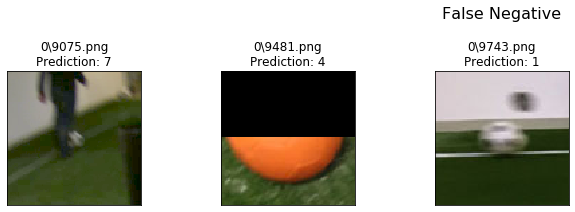

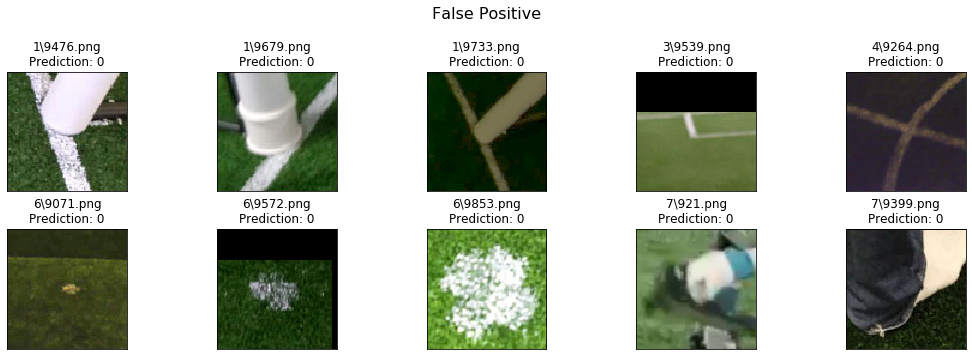

In [10]:
LABEL = 0

indices = np.arange(test_generator.n)
indices = indices[y_true==LABEL]
true_positive_idx = indices[y_pred[indices]==LABEL]
false_negative_idx = indices[y_pred[indices]!=LABEL] 

indices = np.arange(test_generator.n)
indices = indices[y_pred==LABEL]
false_positive_idx = indices[y_true[indices]!=LABEL]

def print_images(indices,suptitel):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(suptitel, fontsize=16)
    for i,idx in enumerate(indices[:10]):
        (img,y) = test_generator[idx]
        filename = test_generator.filenames[idx]
        img = np.squeeze(img)

        ax = plt.subplot(2,5,i+1)
        ax.imshow(img)
        ax.set_title('{}\nPrediction: {}'.format(filename,y_pred[idx]))
        ax.tick_params(bottom=False, left=False,  labelleft=False, labelbottom=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

print_images(false_negative_idx, 'False Negative')
print_images(false_positive_idx, 'False Positive')

# Insights into the Model 

After we have dealt extensively with the training of convolutional networks, we want to allow ourselves a little insight into the inside of such a black box. One of the simplest visualizations is that of the Feature Maps, which is done first. Using the heat map representation, a representation can be generated that describes which aspect of an image is important for the final classification result of the model.

The examples are taken from the source [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) and adapted to the model accordingly. 

## Visualization Feature Maps

### Preprocess simple data

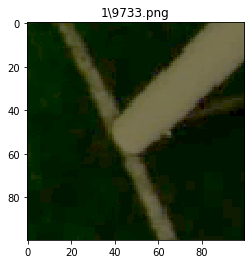

In [13]:
# use either the false_positive or false negative images for visualization
if len(false_positive_idx)!=0: sub_set = false_positive_idx
elif len(false_negative_idx) !=0: sub_set = false_negative_idx
else: raise Exception('NO ERROR: false_positive_idx and false_negative_idx ')

rand_idx = random.randint(0,len(sub_set)-1)
(img,label) = test_generator[sub_set[rand_idx]]
filename = test_generator.filenames[sub_set[rand_idx]]

image2predict = img.copy()

img = np.squeeze(img)

plt.imshow(img)
plt.title(filename)
plt.show()

### Show each layer channels (8 Top layer)

C:\ProgramData\Anaconda3\envs\py3_keras\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


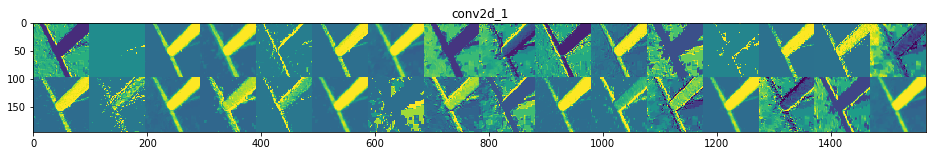

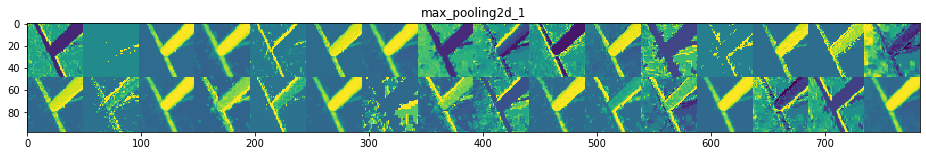

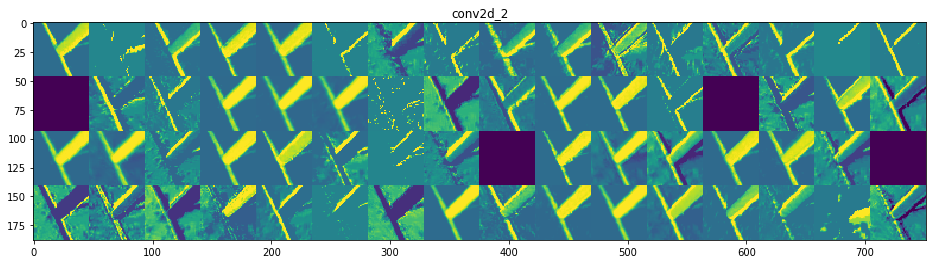

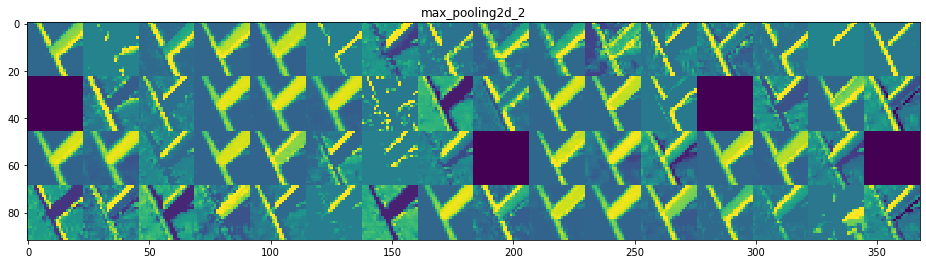

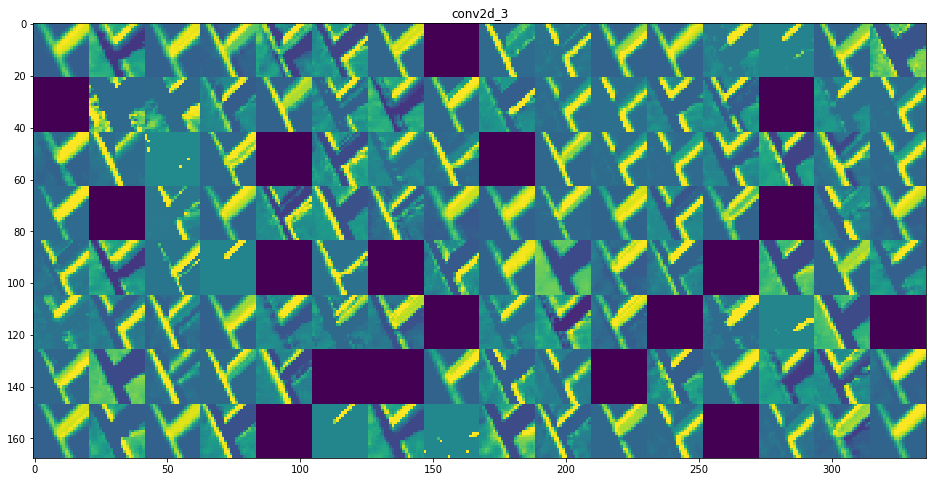

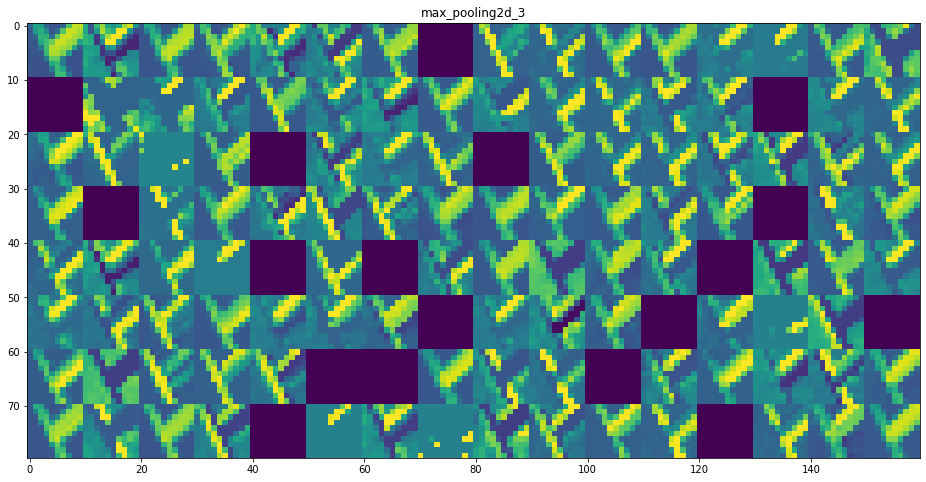

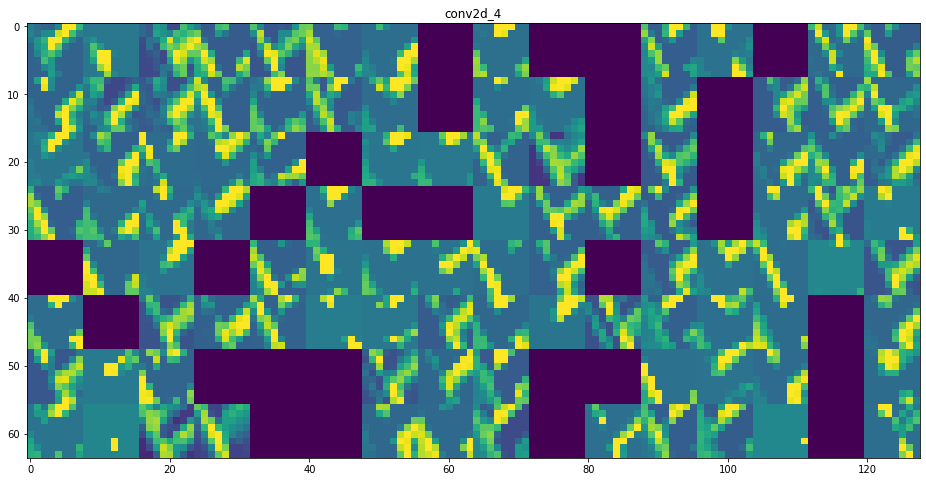

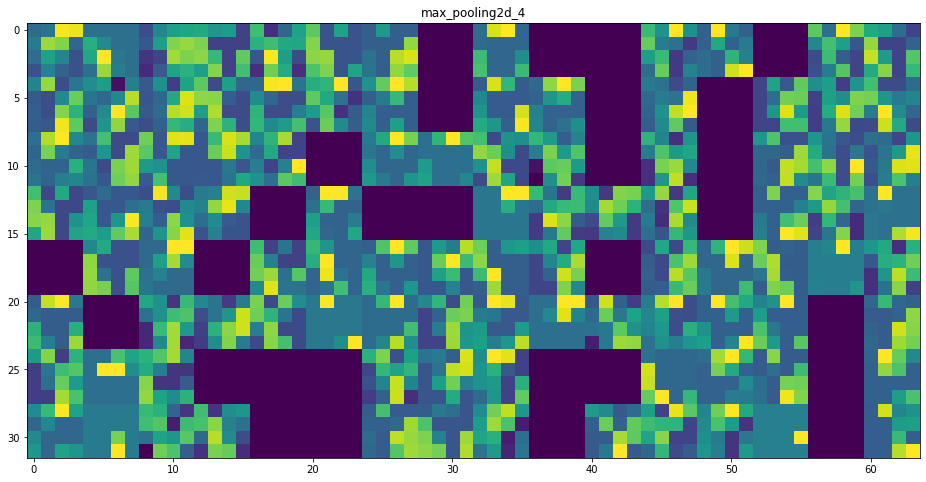

In [14]:
layer_outputs = [layer.output for layer in model.layers[:8]]

activation_model = keras.models.Model(inputs=model.input,outputs=layer_outputs)

activations = activation_model.predict(image2predict)

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names,activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row *size)).astype(np.uint8)
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size : (col+1)*size , row*size : (row+1)*size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='viridis')

## Heat map Visualization

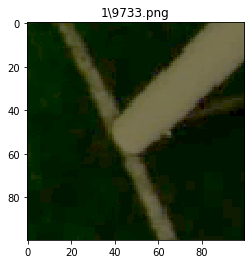

In [15]:
# Predict sample picture
plt.imshow(np.squeeze(img))
plt.title(filename)
plt.show()

In [16]:
pred = model.predict(image2predict)
pred = np.round(pred, 3)
result = np.argmax(pred)
print(result)

0


In [17]:
model_output = model.output[:,result]

In [18]:
last_layer = model.get_layer('conv2d_4')

In [19]:
grads = K.gradients(model_output,last_layer.output)[0]

pooled_grads = K.mean(grads, axis = (0,1,2))

iterate = K.function([model.input],[pooled_grads, last_layer.output[0]])

pooled_grads_value , conv_layer_output_value = iterate([image2predict])

i=0
while i<128:
    conv_layer_output_value[:,:,i]  *= pooled_grads_value[i]
    i += 1

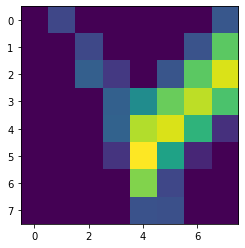

In [20]:
img_cv = cv2.imread(os.path.join(TEST_DIR,filename))

heatmap = np.mean(conv_layer_output_value,axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

heatmap = cv2.resize(heatmap,(img_cv.shape[1],img_cv.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

#heatmap = cv2.cvtColor(heatmap,cv2.COLOR_RGB2BGR)

#heatmap

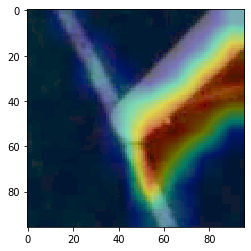

In [21]:
superimposed_image = heatmap * 0.4 + img_cv
# opencv conversions 
cv2.imwrite('superimposed_image.png', superimposed_image)
plt.imshow(plt.imread('superimposed_image.png'))

## Convnet Filter Visualization

In [ ]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x,0,1)
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

In [ ]:
def generate_pattern(layer_name,filter_index,size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input],[loss,grads])
    
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
from IPython import display
progress_info = display.DisplayHandle()
progress_info.display('')

LAYER_NAME = 'conv2d_4'
channels_count = model.get_layer(LAYER_NAME).output.shape[-1].value

w = DATA_SHAPE[0]
h = DATA_SHAPE[1]
margin = 10
COLS = 8
rows = channels_count//COLS

result = np.zeros((h * rows + (rows-1)*margin,w * COLS + (COLS-1)*margin,3),dtype=np.uint8)
plt.figure(figsize=(25,35))

for i in range(channels_count):
    img = generate_pattern(LAYER_NAME,i,w)
    
    col = i % COLS
    row = i // COLS
    
    from_x, to_x = col*w+margin*col,(col*w+w)+margin*col
    from_y, to_y = row*h+margin*row,(row*w+w)+margin*row
    #print(row,col)
    #print('IMAGE_POS: X:',from_x,':', to_x,'Y:',from_y,':',to_y  )
    result[from_y:to_y,from_x:to_x] = img
    progress_info.update('PROCESSED CHANNELS: {} of {}'.format(i+1,channels_count))
    
plt.imshow(result)